In [99]:
!pip install pytorch_forecasting pytorch_lightning

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/deepar.html

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = '/content/drive/MyDrive/Capstone 2024-25/m5' # Upload the folder onto your own Google Drive and change the path here

## Item Levl - RAM issues when merge sales & calender

In [4]:
# resample data frequency to be hourly
print('Loading raw data...')
sales_path = os.path.join(base_path, 'sales_train_evaluation.csv')
calendar_path = os.path.join(base_path, 'calendar.csv')
price_path = os.path.join(base_path, 'sell_prices.csv')

Loading raw data...


In [5]:
key_cols = ['date', 'time_from_start', 'id']
meta_key_cols = ['id']
timestamp_cov_cols = ['month', 'day']

In [6]:
sales_df = pd.read_csv(sales_path)
cat_cols = ['id', 'cat_id', 'store_id', 'state_id']
num_cols = [col for col in sales_df.columns if col not in (cat_cols + ['item_id', 'dept_id'])]
sales_df['id'] = sales_df.apply(lambda row: str(row['store_id']) + '-' + str(row['item_id']),axis=1)


In [7]:
sales_df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,CA_1-HOBBIES_1_001,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,CA_1-HOBBIES_1_002,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,CA_1-HOBBIES_1_003,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,CA_1-HOBBIES_1_004,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,CA_1-HOBBIES_1_005,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,WI_3-FOODS_3_823,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,WI_3-FOODS_3_824,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,WI_3-FOODS_3_825,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,WI_3-FOODS_3_826,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [8]:
meta_df = sales_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]

sales_df = sales_df.drop(columns=[col for col in meta_df.columns if col not in meta_key_cols])
sales_df = pd.melt(sales_df, id_vars='id', var_name='date', value_name='target')

In [9]:
# Merge sales_df with meta_df using 'id' as the key
sales_df = pd.merge(sales_df, meta_df, on='id', how='left')

In [10]:
del meta_df

In [11]:
sales_df.rename(columns={'date': 'd'}, inplace=True)

In [12]:
sales_df

,id,d,target,item_id,dept_id,cat_id,store_id,state_id
0,CA_1-HOBBIES_1_001,d_1,0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
1,CA_1-HOBBIES_1_002,d_1,0,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA
2,CA_1-HOBBIES_1_003,d_1,0,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA
3,CA_1-HOBBIES_1_004,d_1,0,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA
4,CA_1-HOBBIES_1_005,d_1,0,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA
...,...,...,...,...,...,...,...,...
59181085,WI_3-FOODS_3_823,d_1941,1,FOODS_3_823,FOODS_3,FOODS,WI_3,WI
59181086,WI_3-FOODS_3_824,d_1941,0,FOODS_3_824,FOODS_3,FOODS,WI_3,WI
59181087,WI_3-FOODS_3_825,d_1941,2,FOODS_3_825,FOODS_3,FOODS,WI_3,WI
59181088,WI_3-FOODS_3_826,d_1941,0,FOODS_3_826,FOODS_3,FOODS,WI_3,WI


### Merge with Calender Data

In [13]:
calendar_df = pd.read_csv(calendar_path)

In [14]:
calendar_df.set_index(['d'], inplace=True)
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
all_min_date = min(calendar_df['date'])
calendar_df['time_from_start'] = (calendar_df['date'] - all_min_date).dt.days
date_map = calendar_df['time_from_start'].to_dict()
sales_df['time_from_start'] = sales_df['d'].map(date_map)

In [15]:
event_types = ['Sporting', 'Cultural', 'National', 'Religious']

# Initialize new columns with False
for event in event_types:
  calendar_df[event] = False

# Set True where event_type_1 or event_type_2 matches the event type
for event in event_types:
  calendar_df[event] = calendar_df[['event_type_1', 'event_type_2']].apply(
    lambda row: event in row.values if not row.isnull().all() else False, axis=1
  )

In [16]:
# Select only the necessary columns from calendar_df (date + snap columns)
snap_columns = [col for col in calendar_df.columns if col.startswith('snap_')]
calendar_df.drop(columns=['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'] + snap_columns, inplace=True)

In [17]:
calendar_df

,date,wm_yr_wk,weekday,wday,month,year,time_from_start,Sporting,Cultural,National,Religious
d,,,,,,,,,,,
d_1,2011-01-29,11101,Saturday,1,1,2011,0,False,False,False,False
d_2,2011-01-30,11101,Sunday,2,1,2011,1,False,False,False,False
d_3,2011-01-31,11101,Monday,3,1,2011,2,False,False,False,False
d_4,2011-02-01,11101,Tuesday,4,2,2011,3,False,False,False,False
d_5,2011-02-02,11101,Wednesday,5,2,2011,4,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
d_1965,2016-06-15,11620,Wednesday,5,6,2016,1964,False,False,False,False
d_1966,2016-06-16,11620,Thursday,6,6,2016,1965,False,False,False,False
d_1967,2016-06-17,11620,Friday,7,6,2016,1966,False,False,False,False


### Merge Sales and Calender Data

In [ ]:
sales_train_evaluation_long = sales_df.merge(calendar_df, on="time_from_start", how="left")
sales_train_evaluation_long.head()

In [19]:
del calendar_df
del sales_df

## Use store level cleaned data

In [100]:
base_path = '/content/drive/MyDrive/Capstone 2024-25/store_level_data' # Upload the folder onto your own Google Drive and change the path here

In [101]:
price = pd.read_csv(os.path.join(base_path,"price_df.csv"))
print(f"len(price):{len(price)}")
price.head()

len(price):6841121


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [3]:
calendar = pd.read_csv("calendar_df.csv")  # Load calendar dataset
print(f"len(calendar):{len(calendar)}")  # Print the number of rows in calendar
calendar

len(calendar):1969


,date,time_from_start,Sporting,Cultural,National,Religious
0,2011-01-29,0,False,False,False,False
1,2011-01-30,1,False,False,False,False
2,2011-01-31,2,False,False,False,False
3,2011-02-01,3,False,False,False,False
4,2011-02-02,4,False,False,False,False
...,...,...,...,...,...,...
1964,2016-06-15,1964,False,False,False,False
1965,2016-06-16,1965,False,False,False,False
1966,2016-06-17,1966,False,False,False,False
1967,2016-06-18,1967,False,False,False,False


In [4]:
sales_train_evaluation_long = pd.read_csv("sales_df.csv")
print(f"len(sales_train_evaluation_long): {len(sales_train_evaluation_long)}")
sales_train_evaluation_long.head()

len(sales_train_evaluation_long): 58230


,id,target,time_from_start,state
0,CA_1-FOODS,3239,0,CA
1,CA_1-HOBBIES,556,0,CA
2,CA_1-HOUSEHOLD,542,0,CA
3,CA_2-FOODS,2193,0,CA
4,CA_2-HOBBIES,538,0,CA


In [5]:
sales_train_evaluation_long = sales_train_evaluation_long.merge(calendar, on="time_from_start", how="left")
print(f"len(sales_train_evaluation_long): {len(sales_train_evaluation_long)}")
sales_train_evaluation_long.head()

len(sales_train_evaluation_long): 58230


,id,target,time_from_start,state,date,Sporting,Cultural,National,Religious
0,CA_1-FOODS,3239,0,CA,2011-01-29,False,False,False,False
1,CA_1-HOBBIES,556,0,CA,2011-01-29,False,False,False,False
2,CA_1-HOUSEHOLD,542,0,CA,2011-01-29,False,False,False,False
3,CA_2-FOODS,2193,0,CA,2011-01-29,False,False,False,False
4,CA_2-HOBBIES,538,0,CA,2011-01-29,False,False,False,False


In [6]:
sales_train_evaluation_long

,id,target,time_from_start,state,date,Sporting,Cultural,National,Religious
0,CA_1-FOODS,3239,0,CA,2011-01-29,False,False,False,False
1,CA_1-HOBBIES,556,0,CA,2011-01-29,False,False,False,False
2,CA_1-HOUSEHOLD,542,0,CA,2011-01-29,False,False,False,False
3,CA_2-FOODS,2193,0,CA,2011-01-29,False,False,False,False
4,CA_2-HOBBIES,538,0,CA,2011-01-29,False,False,False,False
...,...,...,...,...,...,...,...,...,...
58225,WI_2-HOBBIES,281,1940,WI,2016-05-22,False,False,False,False
58226,WI_2-HOUSEHOLD,1230,1940,WI,2016-05-22,False,False,False,False
58227,WI_3-FOODS,3484,1940,WI,2016-05-22,False,False,False,False
58228,WI_3-HOBBIES,342,1940,WI,2016-05-22,False,False,False,False


In [66]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

In [67]:
data = sales_train_evaluation_long

In [84]:
# create dataset and dataloaders
max_encoder_length = 90
max_prediction_length = 28

training_cutoff = data["time_from_start"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_from_start <= training_cutoff],
    time_idx="time_from_start",
    target="target",
    categorical_encoders={"id": NaNLabelEncoder().fit(data.id)},
    group_ids=["id"],
    static_categoricals=[
        "id", 'state', 'Sporting', 'Cultural', 'National', 'Religious'
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["target"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/samplers.py:86: UserWarning: Less than 128 samples available for 1796 prediction times. Use batch size smaller than 128. First 10 prediction times with small batch sizes: [91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  warnings.warn(


In [85]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

<ipython-input-85-4df6211def71>:2: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/pyt

tensor(0.2211)

In [74]:
import pytorch_forecasting as ptf

In [86]:
pl.seed_everything(42)

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['

In [76]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 5.0118723362727224e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 5.0118723362727224e-05
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_1f17e096-ba52-4dfc-a0e5-cc270d829f97.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_1f17e096-ba52-4dfc-a0e5-cc270d829f97.ckpt


suggested learning rate: 5.0118723362727224e-05


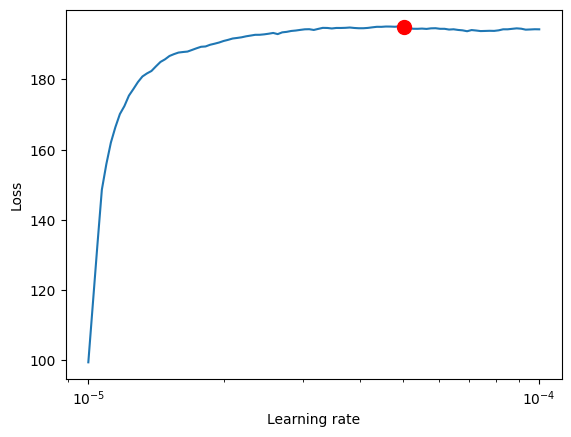

In [87]:
res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e-4,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [88]:
from pytorch_forecasting.metrics import NormalDistributionLoss

In [94]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=0.001,
    log_interval=10,
    log_val_interval=1,
    hidden_size=32,
    rnn_layers=2,
    optimizer="Adam",
    dropout=0.1,
    loss=NormalDistributionLoss(),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                   | Type                   | Params | Mode 
--------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [95]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [96]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


tensor(139.5397)

In [97]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


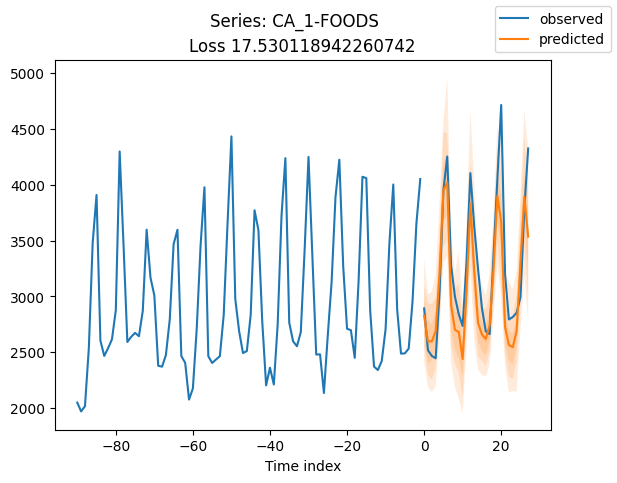

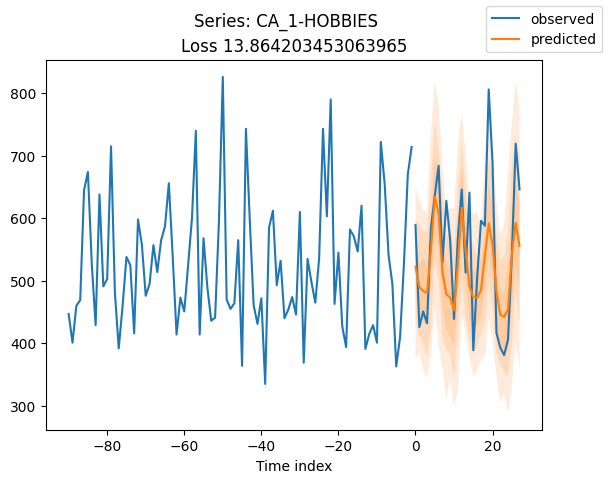

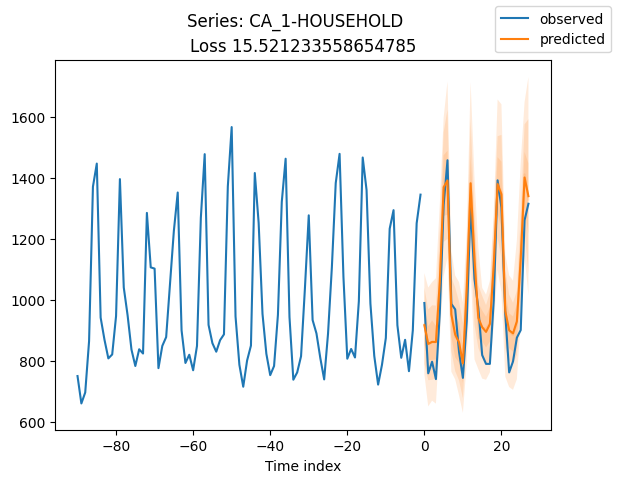

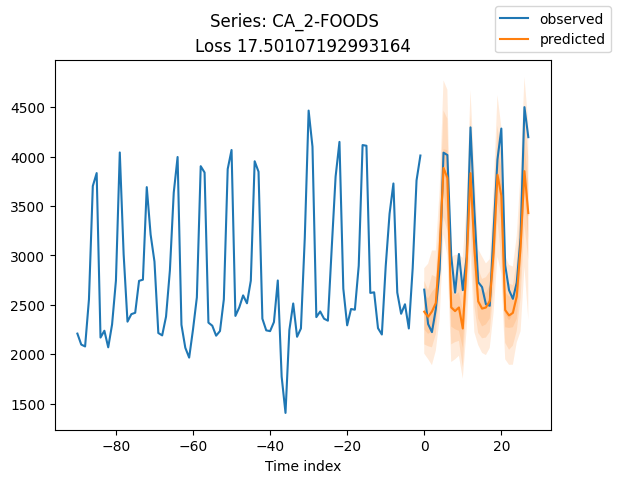

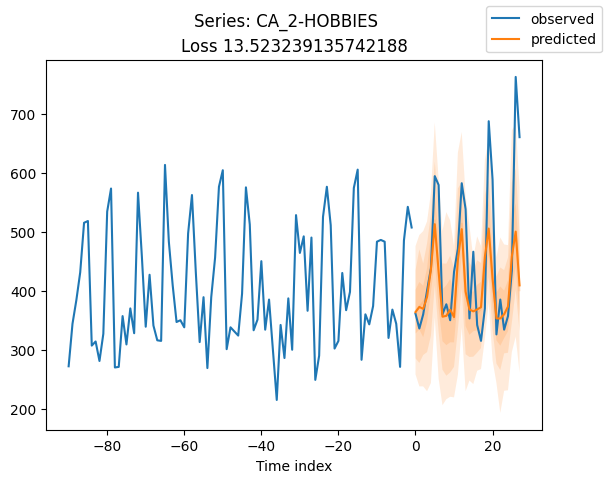

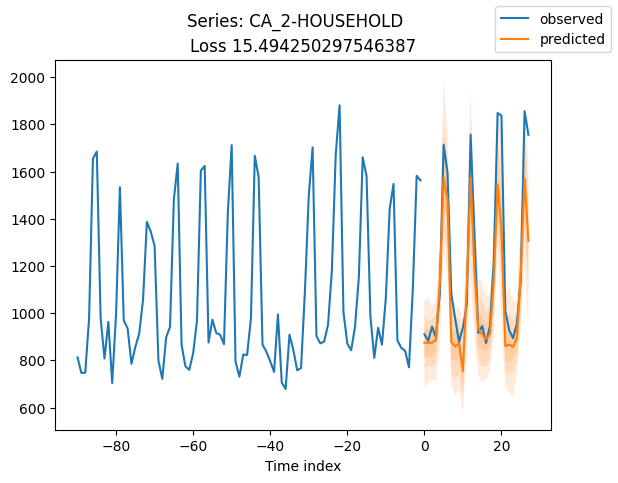

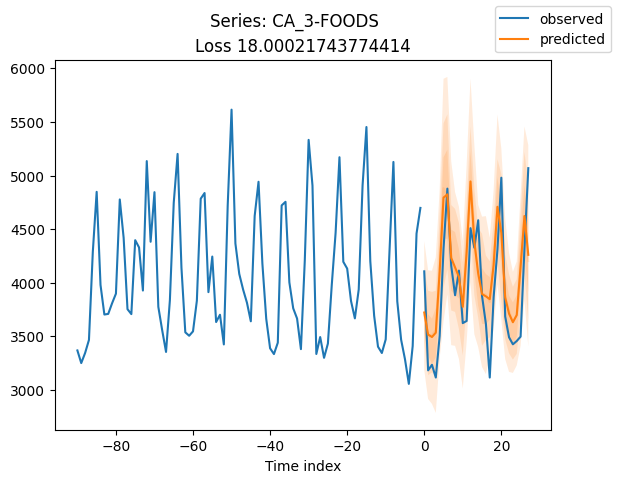

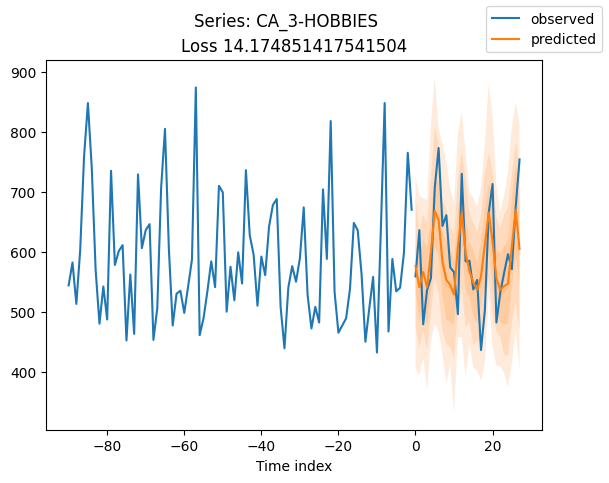

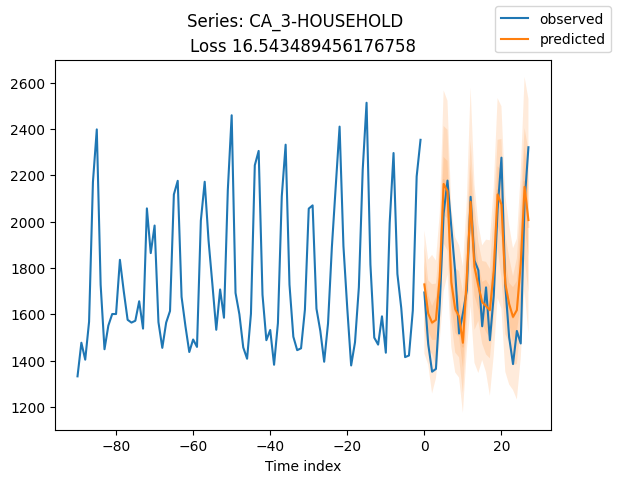

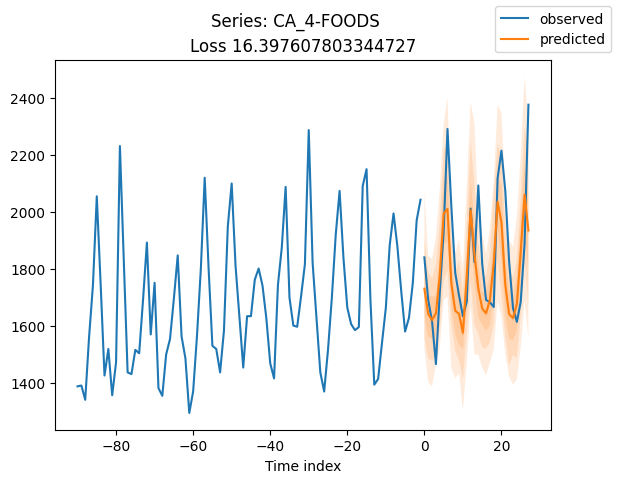

In [98]:
series = validation.x_to_index(raw_predictions.x)["id"]
for idx in range(10):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")